# **MNIST-1D**: Metalearning a learning rate
Sam Greydanus | 2020

In this notebook, we will show how to metalearn a learning rate for an MLP trained on the MNIST-1D datset.

This case study is meant to show the convenience and computational savings of working with the low-dimensional MNIST-1D dataset.  You can find more details at https://github.com/greydanus/mnist1d.

In [14]:
!python -m pip install git+https://github.com/greydanus/mnist1d.git@master

# Download repo directly (gives access to notebooks/models.py and notebooks/train.py)
!git clone https://github.com/greydanus/mnist1d

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time, os
import torch
import torch.nn.functional as F
from torch.autograd import Variable

import mnist1d
project_dir = './'

# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

plt.style.use('https://github.com/greydanus/mnist1d/raw/master/notebooks/mpl_style.txt')

Using: cuda


## Only run this if you're in Google Colab

In [3]:
if True:
    # Only run this in Colab
    from google.colab import drive
    drive.mount('/content/gdrive')
    project_dir = "/content/gdrive/My Drive/Research/mnist1d/"
else:
    project_dir = './'

Mounted at /content/gdrive


## Get the dataset

In [4]:
args = mnist1d.get_dataset_args()
data = mnist1d.get_dataset(args=args)  # by default, this will download a pre-made dataset from the GitHub repo

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each input: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 1000
Length of each input: 40
Number of classes: 10


## First we need a functional representation of an MLP

This is an important first step when doing gradient-based metalearning. The entire inner training loop needs to be end-to-end differentiable and ordinary PyTorch modules and optimizers were not designed with this in mind. People have come up with various ways to get around the issue. My personal favorite is to make PyTorch look more functional and avoid working with objects altogether.


In [5]:
# returns a tuple (state, function) for a vanilla MLP model
def get_functional_mlp(args):
  D, H, O = args.input_size, args.hidden_size, args.output_size
  linear1, linear2 = torch.nn.Linear(D,H), torch.nn.Linear(H,O)
  params = [linear1.weight, linear1.bias, linear2.weight, linear2.bias]
  params = [torch.Tensor(p.reshape(-1)) for p in params]
  param_vec = torch.cat(params)

  def forward_fn(x, param_vec):
    pointer = 0
    W1 = param_vec[pointer:pointer+D*H].reshape(H,D)
    pointer += D*H
    b1 = param_vec[pointer:pointer+H].reshape(1,-1)
    pointer += H
    W2 = param_vec[pointer:pointer+H*O].reshape(O,H)
    pointer += O*H
    b2 = param_vec[pointer:pointer+O].reshape(1,-1)

    h = torch.tanh((W1 @ x.t()).t() + b1)
    logits = (W2 @ h.t()).t() + b2
    return logits
  return param_vec, forward_fn

## Inner optimization loop
In the inner loop, we'll train an MLP to classify MNIST-1D images.

In [6]:
def inner_optimization(learning_rate, model, args, data):
  torch.manual_seed(args.seed)
  (param_vec, fwd_fn) = model
  x_train, x_test = torch.Tensor(data['x']), torch.Tensor(data['x_test'])
  y_train, y_test = torch.LongTensor(data['y']), torch.LongTensor(data['y_test'])

  criterion = torch.nn.CrossEntropyLoss()
  results = {'train_losses': []}
  for step in range(args.total_steps):
    bix = (args.batch_ix + (step*args.batch_size))%len(x_train) # batch index
    x, y = x_train[bix:bix+args.batch_size], y_train[bix:bix+args.batch_size]
    loss = criterion(fwd_fn(x,param_vec), y) # forward pass

    grads = torch.autograd.grad(loss, param_vec, retain_graph=True, create_graph=True)[0]
    param_vec = param_vec - learning_rate * grads # SGD update
    results['train_losses'].append(loss)

  results['train_losses'] = torch.stack(results['train_losses'])
  return results

## Outer optimization loop
The outer (meta) optimization objective is to choose the optimal learning rate for the inner model. We can do this by taking the gradient of the average loss over training with respect to the learning rate. This approach is called **gradient-based metalearning** since we are computing an exact gradient by backpropagating through the entire unrolled optimization loop. A good paper on this approach is [Maclaurin et al., 2015](https://arxiv.org/abs/1502.03492): _"Gradient-based Hyperparameter Optimization through Reversible Learning."_

In [7]:
def outer_optimization(inner_args, outer_args):
  torch.manual_seed(outer_args.seed)

  inner_model = get_functional_mlp(inner_args)
  np_inner_lr = np.asarray([inner_args.initial_lr])
  inner_lr = Variable( torch.FloatTensor(np_inner_lr), requires_grad=True)

  results = {'all_losses':[], 'train_losses':[], 'inner_lr':[]}
  t0 = time.time()
  for step in range(outer_args.total_steps):

    # run inner optimization problem
    inner_results = inner_optimization(inner_lr, inner_model, inner_args, data)

    # run outer optimization problem
    outer_loss = inner_results['train_losses'].mean()
    outer_grads = torch.autograd.grad(outer_loss, inner_lr)[0]
    inner_lr = inner_lr - outer_args.learning_rate * outer_grads

    # boring bookkeeping
    results['train_losses'].append(outer_loss.item())
    results['inner_lr'].append(inner_lr.item())
    results['all_losses'].append(inner_results['train_losses'].detach().cpu().numpy())
    if step > 0 and step % outer_args.print_every == 0: # print out training progress
      t1 = time.time()
      print("step: {}, dt: {:.3e}s, mean_inner_loss: {:.3e}, final_inner_loss: {:.3e}, inner_lr: {:.3e}"
          .format(step, t1-t0, results['train_losses'][-1], inner_results['train_losses'][-1], results['inner_lr'][-1]))
      t0 = t1

  return results

## Hyperparameter settings
Since we have two optimization processes, we'll need _two_ sets of hyperparameters. One of the hardest parts of metalearning is keeping the code organized.

In [8]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

def get_inner_args(as_dict=False):
  arg_dict = {'input_size': 40,
              'hidden_size': 50,
              'output_size': 10,
              'batch_size': 50,
              'total_steps': 200,
              'initial_lr': 1e-2,
              'seed': 0,
              'batch_ix': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

def get_outer_args(as_dict=False):
  arg_dict = {'batch_size': 1,
              'learning_rate': 3e-1,
              'total_steps': 50,
              'print_every': 3,
              'seed': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

## Use metalearning to find an optimal learning rate
Let's initialize the learning rate at a very small value and then at a very large value. If both optimization procedures converge to the same final learning rate, then we can trust that they probably found a global or close-to-global minima (FYI, metalearning loss landscapes are notorious for having strange shapes; see Figure 2 of [this paper](https://arxiv.org/abs/1810.10180) for example).

In [9]:
inner_args, outer_args = get_inner_args(), get_outer_args()
inner_args.initial_lr = 1.5
results_trial1 = outer_optimization(inner_args, outer_args)

print()

inner_args, outer_args = get_inner_args(), get_outer_args()
inner_args.initial_lr = 1.5e-1
results_trial2 = outer_optimization(inner_args, outer_args)

step: 3, dt: 1.374e+00s, mean_inner_loss: 1.808e+00, final_inner_loss: 1.588e+00, inner_lr: 1.259e+00
step: 6, dt: 9.249e-01s, mean_inner_loss: 1.762e+00, final_inner_loss: 1.508e+00, inner_lr: 1.044e+00
step: 9, dt: 8.981e-01s, mean_inner_loss: 1.737e+00, final_inner_loss: 1.500e+00, inner_lr: 9.111e-01
step: 12, dt: 9.289e-01s, mean_inner_loss: 1.726e+00, final_inner_loss: 1.491e+00, inner_lr: 8.209e-01
step: 15, dt: 8.998e-01s, mean_inner_loss: 1.721e+00, final_inner_loss: 1.484e+00, inner_lr: 7.606e-01
step: 18, dt: 9.100e-01s, mean_inner_loss: 1.718e+00, final_inner_loss: 1.485e+00, inner_lr: 7.205e-01
step: 21, dt: 8.877e-01s, mean_inner_loss: 1.717e+00, final_inner_loss: 1.488e+00, inner_lr: 6.931e-01
step: 24, dt: 8.972e-01s, mean_inner_loss: 1.717e+00, final_inner_loss: 1.492e+00, inner_lr: 6.735e-01
step: 27, dt: 9.018e-01s, mean_inner_loss: 1.717e+00, final_inner_loss: 1.495e+00, inner_lr: 6.590e-01
step: 30, dt: 9.136e-01s, mean_inner_loss: 1.716e+00, final_inner_loss: 1.49

## Examine our results
Sure enough, both metalearning runs converged to an optimal learning rate of ~0.62. This is the optimal learning rate.

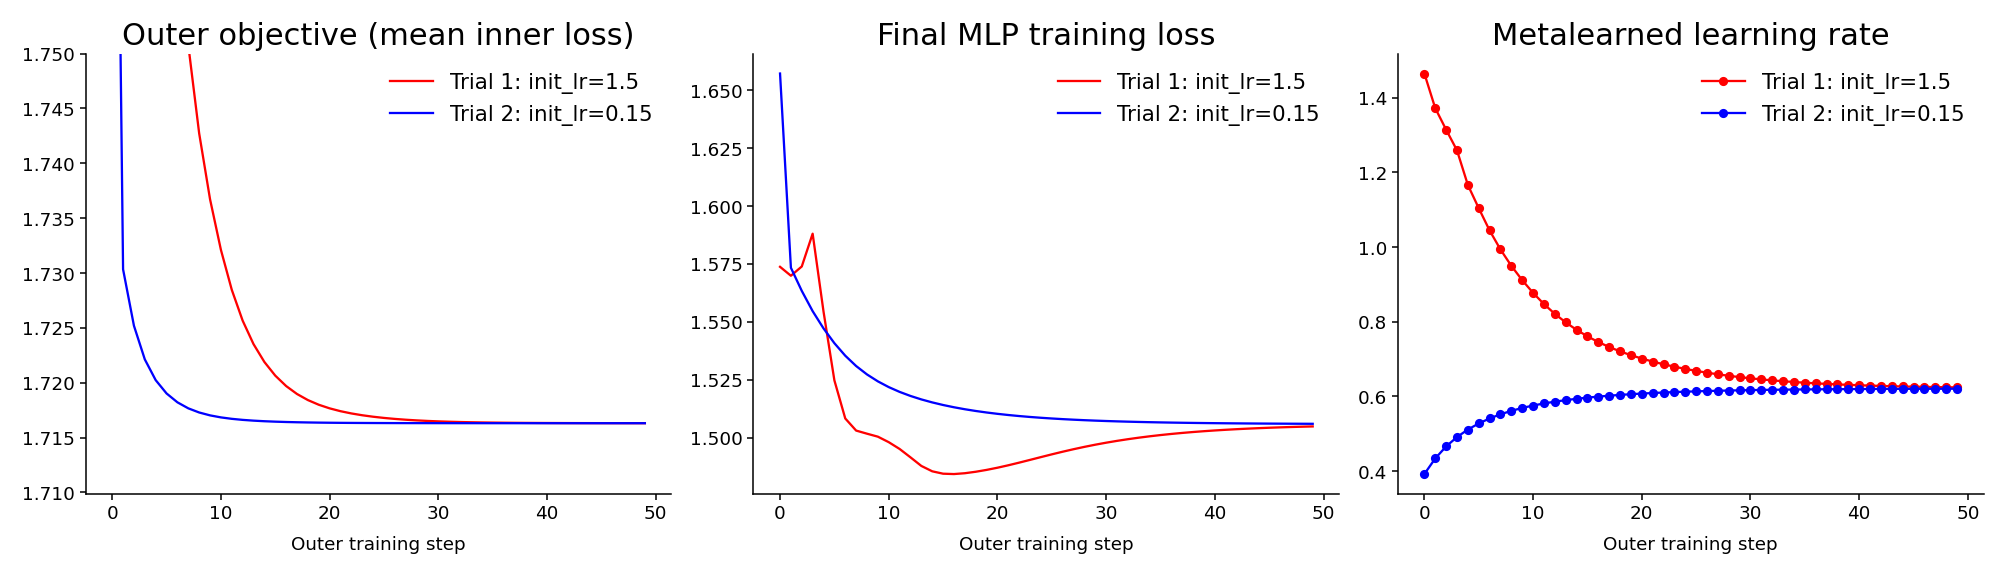

In [13]:
fig = plt.figure(figsize=(9, 2.5), dpi=220)

plt.subplot(1,3,1)
plt.plot(results_trial1['train_losses'], 'r-', label='Trial 1: init_lr=1.5')
plt.plot(results_trial2['train_losses'], 'b-', label='Trial 2: init_lr=0.15')
plt.title('Outer objective (mean inner loss)', fontsize=10)
plt.xlabel("Outer training step") ; plt.legend(fontsize=7)
plt.ylim(None, 1.75)

plt.subplot(1,3,2)
plt.plot([r[-1] for r in results_trial1['all_losses']], 'r-', label='Trial 1: init_lr=1.5')
plt.plot([r[-1] for r in results_trial2['all_losses']], 'b-', label='Trial 2: init_lr=0.15')
plt.title('Final MLP training loss', fontsize=10)
plt.xlabel("Outer training step") ; plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.plot(results_trial1['inner_lr'], 'r.-', label='Trial 1: init_lr=1.5')
plt.plot(results_trial2['inner_lr'], 'b.-', label='Trial 2: init_lr=0.15')
plt.title('Metalearned learning rate', fontsize=10)
plt.xlabel("Outer training step") ; plt.legend(fontsize=7)

# plt.tight_layout() ;
plt.show()

os.makedirs(project_dir + 'figures/', exist_ok=True)
fig.savefig(project_dir + 'figures/metalearn_lr.png')
fig.savefig(project_dir + 'figures/metalearn_lr.pdf')